In [1]:
from __future__ import annotations
import json
import re
import pandas as pd
import camelot
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass
from typing import Any, Dict, Optional

from pydantic import BaseModel, Field
from langchain_ollama import ChatOllama
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END, START
from dotenv import load_dotenv
load_dotenv()

DEFAULT_TOL = 0.05

In [2]:
# ----------------------------
# Data structures
# ----------------------------
@dataclass
class Artifacts:
    erp_df: Optional[pd.DataFrame] = None
    bank_df: Optional[pd.DataFrame] = None
    normalized_erp: Optional[pd.DataFrame] = None
    normalized_bank: Optional[pd.DataFrame] = None
    reconciled: Optional[Dict[str, Any]] = None
    llm_notes: Optional[str] = None
    summary: Optional[pd.DataFrame] = None

class RecoState(BaseModel):
    user_query: str = ""
    artifacts: Dict[str, Any] = Field(default_factory=dict)
    step: str = "start"
    tol: float = DEFAULT_TOL

In [ ]:
# ----------------------------
# Loading
# ----------------------------
def load_erp(path: str) -> pd.DataFrame:
    df = pd.read_excel(path)
    df.rename(columns={"Invoice ID": "Invoice"}, inplace=True)
    df.dropna(inplace=True)
    return df[:20]

def load_bank(path: str) -> pd.DataFrame:
    tables = camelot.read_pdf(path, pages="all")
    dfs = [t.df for t in tables]
    full_df = pd.concat(dfs, ignore_index=True)

    full_df.columns = full_df.iloc[0]   # assign row 0 as header
    full_df = full_df.drop(0).reset_index(drop=True)  # drop the header row and reset index

    # Extract invoice ID from description
    full_df["Invoice"] = full_df["Description"].str.extract(r"(INV\d+)", expand=False)
    full_df.dropna(inplace=True)
    return full_df[:20]


In [4]:
# ----------------------------
# Agent-based Nodes
# ----------------------------
def node_ingest(state: RecoState, config=None) -> RecoState:
    print("\n=== NODE: INGEST ===")
    args = config.get("configurable", {}) if config else {}
    erp_path = args.get("erp_path")
    bank_path = args.get("bank_path")

    erp_df = load_erp(erp_path)
    bank_df = load_bank(bank_path)

    state.artifacts["erp_df"] = erp_df
    state.artifacts["bank_df"] = bank_df
    state.step = "ingested"
    return state


def clean_json_output(text: str) -> str:
    if not isinstance(text, str):
        return text

    cleaned = re.sub(r"```(?:json)?", "", text, flags=re.IGNORECASE).replace("```", "")
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("None", "null")
    cleaned = cleaned.replace("True", "true").replace("False", "false")
    cleaned = re.sub(r"'", '"', cleaned)

    # Fix: Remove JS-style comments
    cleaned = re.sub(r"//.*", "", cleaned)

    # Fix: Remove trailing commas before closing lists/objects
    cleaned = re.sub(r",\s*([\]}])", r"\1", cleaned)

    return cleaned



def ensure_dataframe(output) -> pd.DataFrame:
    try:
        if isinstance(output, pd.DataFrame):
            return output
        elif isinstance(output, list):
            return pd.DataFrame(output)
        elif isinstance(output, dict):
            # If dict of scalars → single row
            if all(not isinstance(v, (list, dict)) for v in output.values()):
                return pd.DataFrame([output])
            else:
                return pd.DataFrame(output)
        elif isinstance(output, str):
            cleaned = clean_json_output(output)
            parsed = json.loads(cleaned)
            return ensure_dataframe(parsed)
        else:
            print(f"[ENSURE_DF] Unexpected output type: {type(output)}")
            return pd.DataFrame()
    except Exception as e:
        print(f"[ENSURE_DF] Normalization failed: {e}")
        return pd.DataFrame()


In [5]:
def node_normalize(state: RecoState, config=None) -> RecoState:
    print("\n=== NODE: NORMALIZE ===")
    llm = ChatOllama(model="phi4-mini:3.8b")
    # llm = ChatOllama(model="llama3.2")

    erp_df = state.artifacts["erp_df"]
    bank_df = state.artifacts["bank_df"]

    print("[NORMALIZE] ERP DF (head):\n", erp_df.head())
    print("[NORMALIZE] BANK DF (head):\n", bank_df.head())

    normalize_prompt = f"""
    You are a data normalization agent.
    Standardize this dataframe to have the following columns:
    - Date (YYYY-MM-DD)
    - Invoice (string, extract INV#### if missing)
    - Amount (float)
    - Description (string)
    - RefID (string or None)

    Return ONLY valid JSON (records orientation). No explanations, no markdown.

    Here is the ERP dataframe (head 20 rows as JSON):
    {erp_df.head(20).to_json(orient="records")}
    """

    erp_raw = llm.invoke(normalize_prompt)
    print('[ERP RAW OUTPUT]:\n', erp_raw)
    normalized_erp = ensure_dataframe(getattr(erp_raw, "content", str(erp_raw)))
    print('[NORMALIZED ERP]:\n', normalized_erp.head())

    bank_prompt = normalize_prompt.replace("ERP", "Bank").replace(
        erp_df.head(20).to_json(orient="records"),
        bank_df.head(20).to_json(orient="records")
    )

    bank_raw = llm.invoke(bank_prompt)
    print('[BANK RAW OUTPUT]:\n', bank_raw)
    normalized_bank = ensure_dataframe(getattr(bank_raw, "content", str(bank_raw)))
    print('[NORMALIZED BANK]:\n', normalized_bank.head())

    state.artifacts["normalized_erp"] = normalized_erp
    state.artifacts["normalized_bank"] = normalized_bank
    state.step = "normalized"
    return state



In [ ]:
def node_reconcile(state: RecoState, config=None) -> RecoState:
    print("\n=== NODE: RECONCILE ===")
    llm = ChatOllama(model="phi4-mini:3.8b")
    # llm = ChatOllama(model="llama3.2")

    erp_n = state.artifacts["normalized_erp"]
    bank_n = state.artifacts["normalized_bank"]

    print("[RECONCILE] Normalized ERP head:\n", erp_n.head())
    print("[RECONCILE] Normalized Bank head:\n", bank_n.head())

    reconcile_prompt = f"""
    Perform reconciliation between ERP and Bank tables.
    Steps:
    1. Split bank into Payments vs Adjustments (fees/interest).
    2. Group both ERP and Bank by Invoice and sum amounts.
    3. Detect duplicates (Invoice + Amount).
    4. Merge ERP vs Bank on Invoice.
    5. For each Invoice classify as:
       - Matched
       - Missing in Bank
       - Missing in ERP
       - Amount Mismatch
       - Rounding Difference (within tolerance {state.tol})

    Provide results as a JSON dictionary with these keys:
       - merged
       - matched
       - mismatches
       - rounding
       - missing_in_bank
       - missing_in_erp
       - duplicates
       - adjustments
       - summary

    Return ONLY valid JSON, records orientation. No explanations, no markdown.

    Here is ERP sample data (first 20 rows):
    {erp_n.head(20).to_json(orient="records")}

    Here is Bank sample data (first 20 rows):
    {bank_n.head(20).to_json(orient="records")}
    """

    raw = llm.invoke(reconcile_prompt)
    text_out = getattr(raw, "content", str(raw))
    print("[RECONCILE RAW OUTPUT]:\n", text_out[:500], "...\n")

    try:
        cleaned = clean_json_output(text_out)
        parsed = json.loads(cleaned)
        result = {k: ensure_dataframe(v) for k, v in parsed.items()}
        print('[RECONCILE RESULT KEYS]:', list(result.keys()))
        state.artifacts["reconciled"] = result
        state.artifacts["summary"] = result.get("summary")
    except Exception as e:
        print(f"[RECONCILE ERROR] Failed to parse output: {e}")
        state.artifacts["reconciled"] = {}
        state.artifacts["summary"] = None

    state.step = "reconciled"
    return state


In [7]:
def node_llm_triage(state: RecoState, config=None) -> RecoState:
    print("\n=== NODE: TRIAGE ===")
    llm = ChatOllama(model="phi4-mini:3.8b")
    # llm = ChatOllama(model="llama3.2")

    merged = state.artifacts.get("reconciled", {}).get("merged")
    print("[TRIAGE] Merged DF head:\n", merged.head() if merged is not None else "None")

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a senior Reconciliation Assistant. Analyze discrepancies and recommend next steps."),
        ("human", 
         "Here are discrepancy rows:\n{rows}\n\n"
         "Please group by Status and provide:\n"
         "1) Likely root cause(s)\n"
         "2) Confidence level\n"
         "3) Next action")
    ])

    out = (prompt | llm).invoke({"rows": merged.head(30).to_dict(orient="records") if merged is not None else []})
    print('[TRIAGE RAW OUTPUT]:\n', out)
    state.artifacts["llm_notes"] = getattr(out, "content", str(out))
    state.step = "triaged"
    return state


In [8]:
def node_export(state: RecoState, config=None) -> RecoState:
    print("\n=== NODE: EXPORT ===")
    args = config.get("configurable", {}) if config else {}
    out_path = args.get("out_path", "reconciliation_report_agentic.xlsx")

    with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
        rec = state.artifacts.get("reconciled", {})
        for k, df in rec.items():
            if isinstance(df, pd.DataFrame):
                print(f"[EXPORT] Writing sheet: {k}")
                df.to_excel(writer, sheet_name=k[:30], index=False)
        if state.artifacts.get("llm_notes"):
            print("[EXPORT] Writing AI Notes")
            pd.DataFrame({"AI_Notes": [state.artifacts["llm_notes"]]}).to_excel(writer, sheet_name="AI_Triage_Notes", index=False)

    print(f"[EXPORT COMPLETE] File saved: {out_path}")
    state.step = "exported"
    return state


In [9]:
# ----------------------------
# Graph
# ----------------------------
def build_graph() -> Any:
    g = StateGraph(RecoState)

    g.add_node("ingest", node_ingest)
    g.add_node("normalize", node_normalize)
    g.add_node("reconcile", node_reconcile)
    g.add_node("triage", node_llm_triage)
    g.add_node("export", node_export)

    g.add_edge(START, "ingest")
    g.add_edge("ingest", "normalize")
    g.add_edge("normalize", "reconcile")
    g.add_edge("reconcile", "triage")
    g.add_edge("triage", "export")
    g.add_edge("export", END)

    return g.compile()


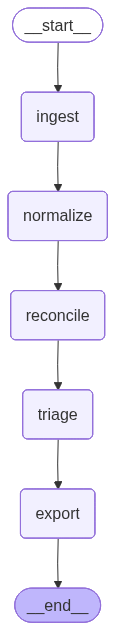

In [10]:
app = build_graph()
app

In [11]:
# ----------------------------
# CLI
# ----------------------------
def main():
    print("\n=== START RECONCILIATION PIPELINE ===")
    erp_path = "/home/sudamasharma/aai/app/data/erp_data.xlsx"
    bank_path = "/home/sudamasharma/aai/app/data/bank_statement.pdf"
    out_path = "/home/sudamasharma/aai/app/data/reconciliation_report_by_agent.xlsx"

    app = build_graph()
    initial = RecoState(user_query="Run reconciliation", tol=0.05)
    config = {"configurable": {"erp_path": erp_path, "bank_path": bank_path, "out_path": out_path}}
    final_state = app.invoke(initial, config=config)

    print("\n=== FINAL SUMMARY ===")
    print(final_state["artifacts"].get("summary"))
    print("\n=== FINAL AI TRIAGE NOTES ===")
    print(final_state["artifacts"].get("llm_notes", "(skipped)"))
    print(f"\n[PIPELINE COMPLETE] Report saved to: {out_path}")


if __name__ == "__main__":
    main()



=== START RECONCILIATION PIPELINE ===

=== NODE: INGEST ===

[LOAD ERP] Loading ERP data from: /home/sudamasharma/aai/app/data/erp_data.xlsx
erp_columns:
 Index(['Date', 'Invoice', 'Amount', 'Status'], dtype='object')
[LOAD ERP] First 5 rows:
          Date  Invoice   Amount     Status
0  2025-02-10  INV0001   267.10  Cancelled
1  2025-02-17  INV0002  1789.75       Paid
2  2025-01-02  INV0003  1144.43  Cancelled
3  2025-01-18  INV0004  1628.39       Paid
4  2025-01-10  INV0005   469.86    Pending

[LOAD BANK] Loading Bank data from: /home/sudamasharma/aai/app/data/bank_statement.pdf
bank_statement_columns:
 Index(['Date', 'Description', 'Amount', 'Ref ID', 'Invoice'], dtype='object', name=0)
[LOAD BANK] First 5 rows:
 0        Date      Description   Amount Ref ID  Invoice
0  2025-02-09  Payment INV0001    267.1      1  INV0001
1  2025-02-15  Payment INV0002  1788.62      2  INV0002
2  2025-01-04  Payment INV0003  1144.43      3  INV0003
3  2025-01-17  Payment INV0004  1628.39      4 